### <u>**Loading Modules**</u>

In [109]:
import numpy as np
import pandas as pd
from math import radians, cos, sin, asin, sqrt, exp
import random
from matplotlib import pyplot as plt
import networkx as nx
import utm

### <u>**Preparing data**</u>

In [110]:
filepath = "Data/Rajasthan.xlsx"
df = pd.read_excel(filepath)
df.rename(columns={"Unnamed: 0" : "Locations", "Latitude": "Latitude (in degrees)",
 "Longitude": "Longitude (in degrees)"}, inplace=True)
df

,Locations,Latitude (in degrees),Longitude (in degrees)
0,Jaipur,26.9124,75.7873
1,Udaipur,24.5854,73.7125
2,Jodhpur,26.2389,73.0243
3,Jaisalmer,26.9157,70.9083
4,Ajmer,26.4499,74.6399
5,Mount_Abu,24.5926,72.7156
6,Bikaner,28.0176,73.3150
7,Bharatpur,27.2152,77.5030
8,Chittorgarh,24.8829,74.6230
9,Bundi,25.4326,75.6483


### <u>**Graph Representation**</u>

We used matrix representation. <br>
Entry(i,j) = distance b/w node i and node j.

### <u>**Coding Uitility Functions**</u>

**Haversine Formula**: To calculate distance between two locations using their latitude and longitude values. <br>
Reference: https://www.geeksforgeeks.org/program-distance-two-points-earth/

In [111]:
# Haversine formula
def dist_formula(lt1,lg1,lt2,lg2):
    lg1 = radians(lg1)
    lg2 = radians(lg2)
    lt1 = radians(lt1)
    lt2 = radians(lt2)
    dlg = lg2 - lg1
    dlt = lt2 - lt1
    a = sin(dlt / 2)**2 + cos(lt1) * cos(lt2) * sin(dlg / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)

In [112]:
def tour_cost(path, distance_matrix):
    dis =0
    for i in range(19):
        ls = [path[i], path[i+1]]
        ls.sort()
        dis += distance_matrix[ls[0]][ls[1]]
    ls = [path[19], path[0]]
    ls.sort()
    dis += distance_matrix[ls[0]][ls[1]]
    return dis

### <u>**Creating Graph**</u>

In [113]:
distance_matrix = np.zeros((20,20)) # distace_matrix[i][j] = distance b/w location i and location j
for i in range(20):
    for j in range(i+1,20):
        distance_matrix[i][j]=dist_formula(df.iloc[i,1],df.iloc[i,2],df.iloc[j,1],df.iloc[j,2])
        distance_matrix[j][i]=distance_matrix[i][j]

In [114]:
G = nx.Graph()
pos = {}
for i in range(20):
    G.add_node(df.iloc[i][0])
    x, y, zone, ut = utm.from_latlon(df.iloc[i][1], df.iloc[i][2]) # to convert long, lat to x-y coordinates
            # reference: https://gis.stackexchange.com/questions/212723/how-can-i-convert-lon-lat-coordinates-to-x-y
    pos[df.iloc[i][0]] = (x,y)

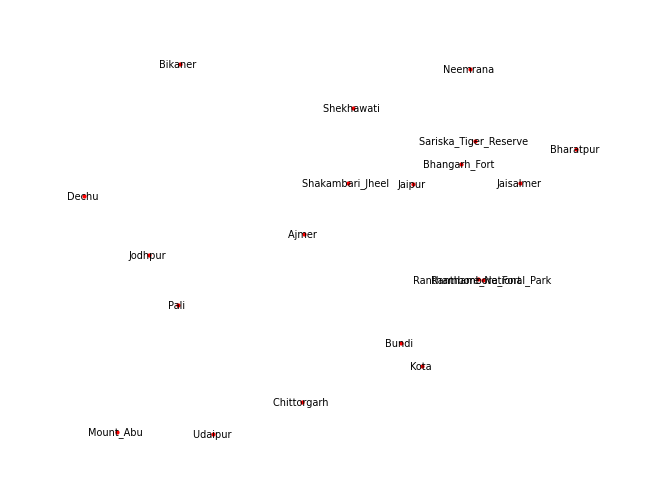

In [115]:
nx.draw(G,pos=pos,with_labels=True, node_color="red", node_size=4, font_size=7)
plt.margins(0.15)
plt.show()

Let's shift Ranthambore_National_Park co-ordinates for visual clarity.

In [116]:
RNPx,RNPy = pos["Ranthambore_National_Park"]
RNPx,RNPy

(650365.3495993316, 2878464.704691522)

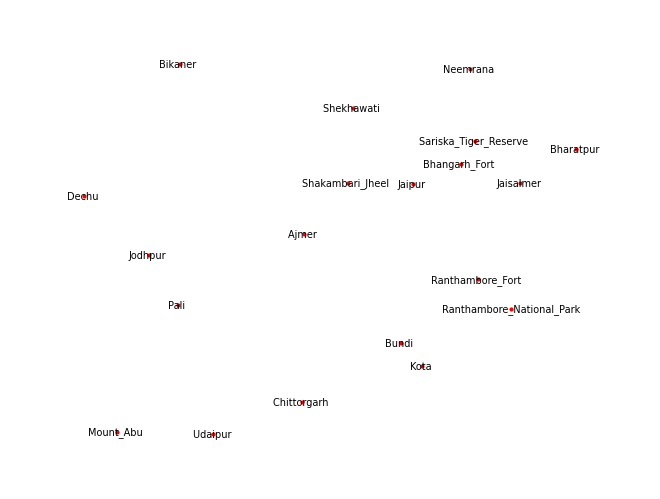

In [117]:
G = nx.Graph()
pos = {}
for i in range(20):
    G.add_node(df.iloc[i][0])
    x, y, zone, ut = utm.from_latlon(df.iloc[i][1], df.iloc[i][2]) # to convert long, lat to x-y coordinates
            # reference: https://gis.stackexchange.com/questions/212723/how-can-i-convert-lon-lat-coordinates-to-x-y
    pos[df.iloc[i][0]] = (x,y)

pos["Ranthambore_National_Park"] = (RNPx+29990,RNPy-29990)

nx.draw(G,pos=pos,with_labels=True, node_color="red", node_size=4, font_size=7)
plt.margins(0.15)
plt.show()

##### *I hid this cell intentionally*

In [187]:
intermediate_costs =[] # y-axis
x=0 # counter for number of actual iterations happened
intermediate_tempr = []

### **<u>Simulated Annealing</u>**

In [189]:
def SA(initial_path, Tm=1000, iter_max=10000, cooling_factor=0.999):
    path = initial_path.copy()
    cost = tour_cost(path=path,distance_matrix=distance_matrix)

    global intermediate_costs
    intermediate_costs.append(cost)
    global intermediate_tempr
    intermediate_tempr.append(Tm)

    for i in range(1,iter_max):
        two_indices = random.sample(range(20),2)
        # two_indices.sort()
        next_path = path.copy()
        next_path[two_indices[0]:two_indices[1]+1] = next_path[two_indices[0]:two_indices[1]+1][::-1] # reverse sublist
        next_cost = tour_cost(next_path,distance_matrix=distance_matrix)

        dE = cost - next_cost # delta Energy

        T = Tm*(cooling_factor**i)
        # T = Tm*(cooling_factor/i)

        if(T == 1e-6):
            break

        try:
            pb = 1/(1+exp(-dE/T))
        except: 
            continue
        if dE > 0:
            path = next_path.copy()
        else:
            #random.random() returns a uniformly distributed pseudo-random floating point number in the range [0, 1).
            # This number is less than a given number pb in the range [0,1) with probability pb
            if  random.random() < pb:
                path = next_path.copy()
        cost = tour_cost(path,distance_matrix=distance_matrix)

        intermediate_costs.append(next_cost)
        intermediate_tempr.append(T)
        global x
        x += 1
        
    final_cost = cost
    final_path = path.copy()
    return final_path

### <u>**Setting Initial Path Randomly**</u>

Total number of nodes/locations: 20

In [170]:
init_path = np.random.permutation(20) # initial solution
print(init_path)

[10 15 17  3 16  5  4 11 12  9  7  0  1 19 14  6 13  2  8 18]


In [171]:
cost = tour_cost(init_path,distance_matrix=distance_matrix)
initial_cost = cost
print("Initial Cost: ",initial_cost)

Initial Cost:  5962.435356516007


In [186]:
final_path = SA(init_path)
final_cost = tour_cost(final_path,distance_matrix=distance_matrix)
print("Final Cost: ",final_cost)

Final Cost:  2087.4424018034333


In [173]:
initial_graph = G.copy()
for i in range(19):
    initial_graph.add_edge(df.iloc[init_path[i]][0],df.iloc[init_path[i+1]][0])
initial_graph.add_edge(df.iloc[init_path[19]][0],df.iloc[init_path[0]][0])

final_graph = G.copy()
for i in range(19):
    final_graph.add_edge(df.iloc[final_path[i]][0],df.iloc[final_path[i+1]][0])
final_graph.add_edge(df.iloc[final_path[19]][0],df.iloc[final_path[0]][0])

Initial Cost:  5962.435356516007  km


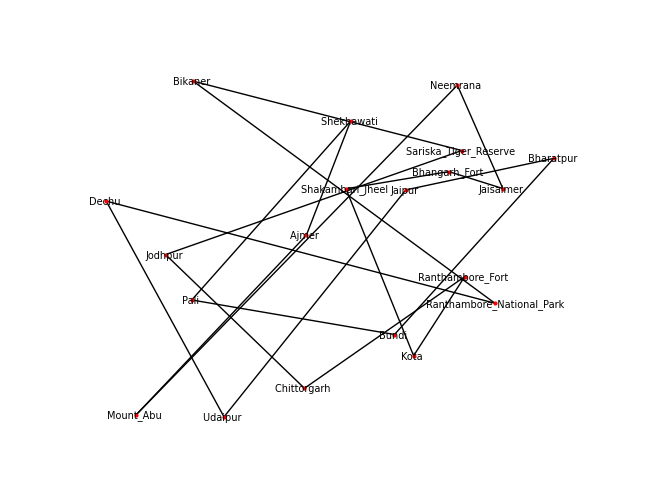

In [174]:
print("Initial Cost: ", initial_cost, " km")
nx.draw(initial_graph,pos=pos,with_labels=True, node_color="red", node_size=4, font_size=7)
plt.margins(0.15)
plt.show()

Final Cost:  2137.395657412516  km


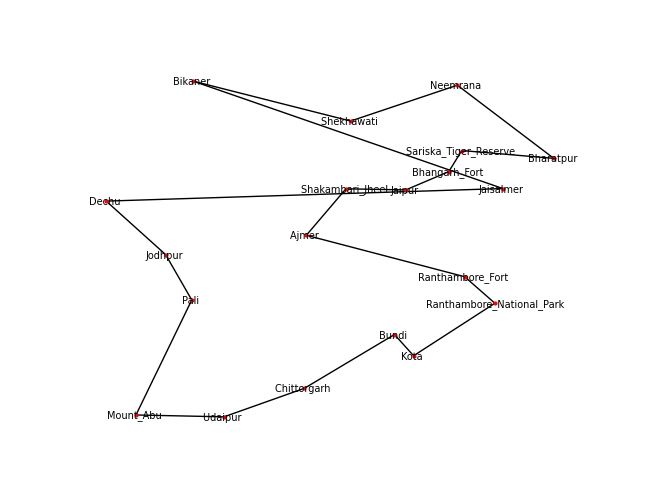

In [175]:
print("Final Cost: ", final_cost, " km")
nx.draw(final_graph,pos=pos,with_labels=True, node_color="red", node_size=4, font_size=7)
plt.margins(0.15)
plt.show()

### **<u>Graphical Analysis</u>**

##### *hidden intentionally*

In [178]:
import warnings
warnings.filterwarnings('ignore')
cooling_factors = [0.111, 0.222, 0.333, 0.444, 0.555, 0.666, 0.777, 0.888, 0.999]
cooling_factors_str = ["0.111", "0.222", "0.333", "0.444", "0.555", "0.666", "0.777", "0.888", "0.999"]
final_costs = []
for i in range(len(cooling_factors)):
    final_path_ = SA(initial_path=init_path,cooling_factor=cooling_factors[i])
    final_cost_ = tour_cost(final_path_,distance_matrix=distance_matrix)
    final_costs.append(final_cost_)

##### Final cost vs Cooling Factor

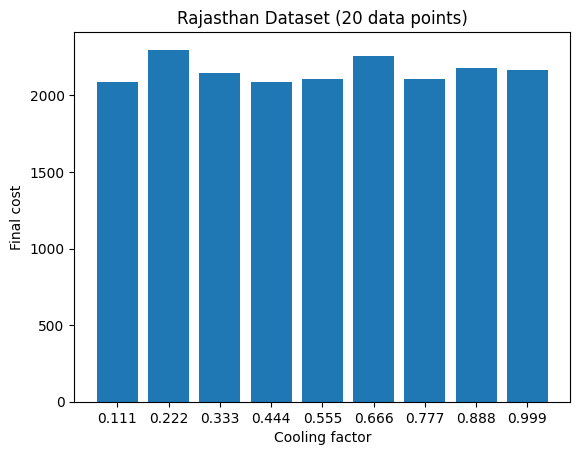

In [179]:
plt.bar(cooling_factors_str,final_costs)
plt.title("Rajasthan Dataset (20 data points)")
plt.xlabel("Cooling factor")
plt.ylabel("Final cost")
plt.show()

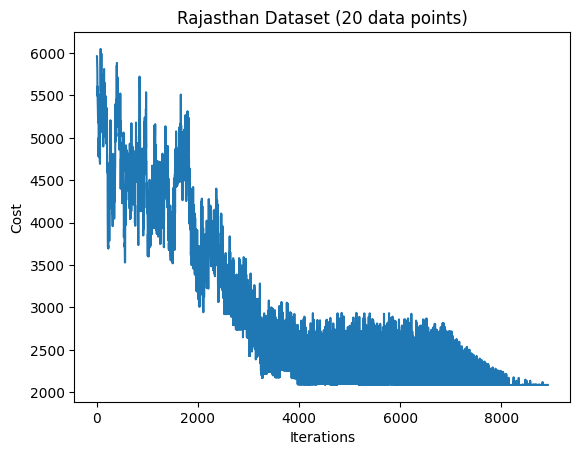

In [180]:
global intermediate_costs
intermediate_costs = []
global x
x = 0
SA(initial_path=init_path)
plt.plot(range(x+1),intermediate_costs)
plt.title("Rajasthan Dataset (20 data points)")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()

In [181]:
initial_tempr = range(1,1000, 20)
final_cost_g3 = []
for i in range(len(initial_tempr)):
    final_path_g3 = SA(initial_path=init_path,Tm=initial_tempr[i])
    final_cost_g3.append(tour_cost(final_path_g3,distance_matrix=distance_matrix))

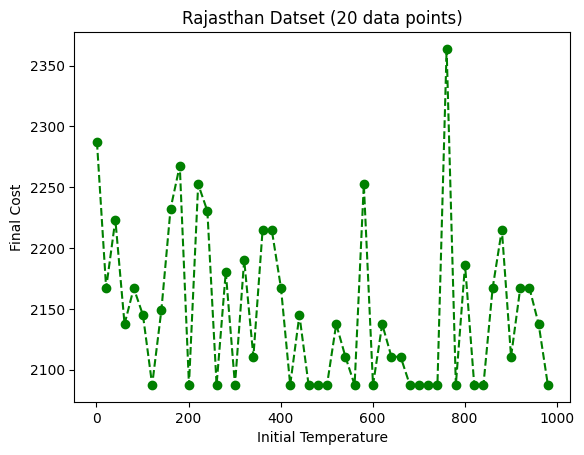

In [183]:
plt.plot(initial_tempr,final_cost_g3, "go--")
plt.title("Rajasthan Datset (20 data points)")
plt.xlabel("Initial Temperature")
plt.ylabel("Final Cost")
plt.show()

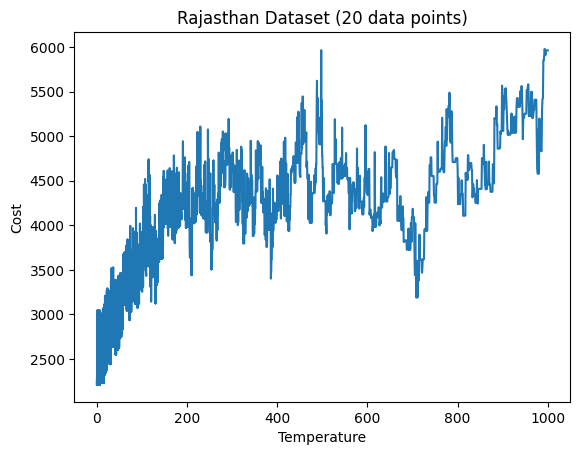

In [190]:
global intermediate_tempr
intermediate_tempr = []
global intermediate_costs
intermediate_costs = []

SA(initial_path=init_path,)
plt.plot(intermediate_tempr, intermediate_costs)
plt.title("Rajasthan Dataset (20 data points)")
plt.xlabel("Temperature")
plt.ylabel("Cost")
plt.show()